In [1]:
import numpy as np
from lib.utils import process_sensor_data
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
# adding to the df_dict
# Loop through each subdirectory in the parent directory


In [2]:
from lib.utils import gen_data_dict
import pickle
dataset_name = "train_station"
# dataset_name = "maze"
if dataset_name != "maze":
    df_dict = process_sensor_data(parent_dir, df_dict)  # only process sensor 2
    data_dict = gen_data_dict(df_dict)
    # process data dict to get the upstream and downstream data
    from lib.utils import seperate_up_down

    data_dict = seperate_up_down(data_dict)
elif dataset_name == "maze":
    with open("./sc_sensor/maze/flow_data.pkl", "rb") as f:
        data_dict = pickle.load(f)

In [3]:

from lib.utils import sliding_win
import torch
from dgl.data.utils import load_graphs
# import pickle
# set seed
torch.manual_seed(1)
#normalization
# x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
#                           std=np.concatenate([x_train, x_val]).std())

# dataset_name = "crossroad"

g_data = load_graphs('./graphs/graphs.bin')    
if dataset_name == "crossroad":
    # file_path = 'graphs/graph_data_crossroad.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][0]

elif dataset_name == "train_station":
    # file_path = 'graphs/graph_data_trainstation.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][1]

elif dataset_name == "maze":
    # file_path = 'graphs/graph_data_maze.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][2]
    
src, dst = g.edges()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if dataset_name == "crossroad":
    train_sc = ['sc_sensor/crossroad2']
    test_sc = ['sc_sensor/crossroad2_2']

if dataset_name == "train_station":
    train_sc = ['sc_sensor/train6']
    test_sc = ['sc_sensor/train3']
    
if dataset_name == "maze":
    train_sc = ['sc_sensor/maze0']
    test_sc = ['sc_sensor/maze0', 'sc_sensor/maze5','sc_sensor/maze8', 'sc_sensor/maze9',
               'sc_sensor/maze10', ]

# x_train, y_train, x_val, y_val, x_test, y_test = generating_ood_dataset(data_dict, train_sc, test_sc, lags=5, horizons=pred_horizon, shuffle=True)
# x_train, y_train, x_val, y_val, x_test, y_test = generating_insample_dataset(data_dict, train_sc,
#                                                                              lags=5,
#                                                                              horizons=pred_horizon,
#                                                                              portion=0.6,
#                                                                              shuffle=True)

chunk_size = 30
lags = 5
# '''Has to >= 2'''
pred_horizon = 7 # 3, 5
x_test, y_test = sliding_win(data_dict["sc_sensor/train1"], lags=lags, horizons=pred_horizon)
num_input_timesteps = x_test.shape[1] # number of input time steps
num_nodes = x_test.shape[2] # number of ancestor nodes, minus the down stream node
# x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
#                           std=np.concatenate([x_train, x_val]).std())


In [7]:
# from Diffusion_Network import Diffusion_Model
# from Diffusion_Network2 import Diffusion_Model
# from Diffusion_Network3_asc import Diffusion_Model
from src.Diffusion_Network4 import Diffusion_Model
# from Diffusion_Network_density import Diffusion_Model_Density
# from Diffusion_Network_UQ import Diffusion_Model_UQ

# model = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)

# model = Diffusion_Model_Density(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)
model = Diffusion_Model(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, device=device, scalar=None)
# chunk_size = 30
# lags = 5
# '''Has to >= 2'''
# pred_horizon = 5 # 3, 5
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
if dataset_name == "crossroad":
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3_cross.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/online_diffusion.pt"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/offline_diffusion_uq_cross.pth"))
    model.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
if dataset_name == "train_station":
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network4.pth"))
    model.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/online_diffusion_density.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_density.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq.pth"))
if dataset_name == "maze":
    model.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network4_maze.pth"))

In [6]:
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    x = torch.FloatTensor(x_test.transpose(2, 0, 1))
    y = torch.FloatTensor(y_test.transpose(2, 0, 1))
    g.ndata['feature'] = x # [node, batch_size, num_timesteps_input]
    g.ndata['label'] = y # [node, batch_size, pred_horizon]
    # v = model.velocity_model(x_up, x_down).numpy()
    model(g.ndata['feature'][src], g.ndata['feature'][dst])
    # flow = torch.sum(x_up, dim=2).numpy()
    total_flow = torch.mean(torch.cat([x_up, x_down], dim=-1), dim=-1).numpy()
flow = model.g.edata['message']
speed = model.g.edata['v']
F = model.g.edata['F']

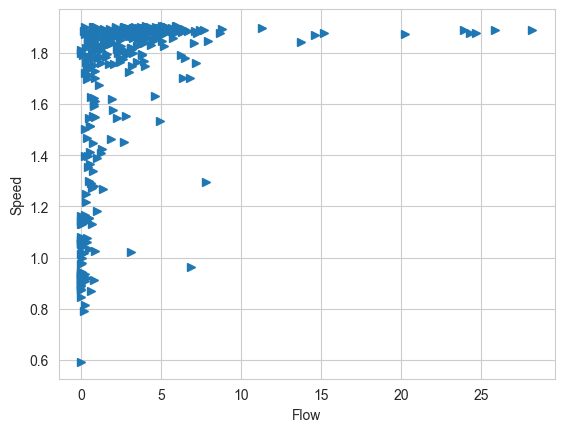

In [15]:
import matplotlib.pyplot as plt
src_point =22
dst_point = 2
edge_id = np.where((src == src_point) & (dst == dst_point))[0]
# plt.plot(flow[edge_id, :250].squeeze(), speed[edge_id, :250].squeeze(), '*')
# plt.plot(flow[edge_id, 250:].squeeze(), speed[edge_id, 250:].squeeze(), '>')
plt.xlabel('Flow')
plt.ylabel('Speed')
plt.plot(flow[edge_id, :].squeeze(), speed[edge_id, :].squeeze(), '>')

In [8]:
#netowrk2
# g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
# pred = model.inference(g.ndata['feature'][src], g.ndata['feature'][dst])

In [9]:
#network
# g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
# g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
# z = model.transition_probability(g.ndata['feature'])
# g.ndata['embedding'] = z   # for attention
# g.apply_edges(model.transition_probability.edge_attention)

In [7]:
# generate matrix with the element is e
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
    # atten_mat = atten_mat.numpy()

In [83]:
# generate matrix with the element is e
np.around(atten_mat[..., -1].numpy(), 3)

# visualize the attention matrix

In [8]:
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    alpha_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        # alpha_mat[src[i], dst[i], :] = g.edata['alpha'][i, :]
        alpha_mat[src[i], dst[i], :] = g.edata['F'][i, :]


In [9]:
import seaborn as sns

# plt.figure(figsize=(10, 8))
# sns.heatmap(alpha_mat[..., -1], cmap="YlGnBu")
sns.heatmap(torch.mean(alpha_mat, dim=-1), cmap="YlGnBu")

In [12]:
# plt.figure(figsize=(10, 8))
sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")

In [15]:
sns.heatmap(np.multiply(atten_mat[..., -1].numpy(), alpha_mat[..., -1].numpy()), cmap="YlGnBu")

In [17]:
import dgl
import torch

# Create a simple DGLGraph
# num_nodes = 5
# edges_src = [0, 1, 1, 2, 2, 3, 3, 4]
# edges_dst = [1, 2, 3, 3, 4, 4, 0, 1]
# graph = dgl.graph((edges_src, edges_dst), num_nodes=num_nodes)
# graph.edata['features'] = torch.randn(8, 10)
# src_idx, dst_idx = g.edges()
src_idx = np.unique(src)
# Get edge IDs going out from a specific source node
edge_ids_dict = dict()
for src_node_id in src_idx:
    outbound_edges = np.where(np.array(src) == src_node_id)[0]
    edge_ids_dict[src_node_id] = outbound_edges
    print(src_node_id)
    edge_data = g.edata['e'][outbound_edges, :]
    print(torch.sum(edge_data))
    # assert torch.sum(edge_data) != 354
    print("Edge Data:", edge_data.shape)
    print("outbound_edges:", outbound_edges)

# Extract edge features and destination nodes connected to the specified source node
# edge_data = graph.edata['features'][outbound_edges]
# src_nodes = graph.edges()[0][outbound_edges]
# dst_nodes = graph.edges()[1][outbound_edges]

# print("Edge Data:", edge_data)
# print("Source Nodes:", src_nodes)
# print("Destination Nodes:", dst_nodes)


0
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [46 47 48]
3
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [0 1 2]
4
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [3 4 5]
7
tensor(350.0000)
Edge Data: torch.Size([3, 350])
outbound_edges: [6 7 8]
8
tensor(350.)
Edge Data: torch.Size([5, 350])
outbound_edges: [17 18 19 20 21]
11
tensor(350.)
Edge Data: torch.Size([5, 350])
outbound_edges: [22 23 24 25 26]
12
tensor(350.0000)
Edge Data: torch.Size([5, 350])
outbound_edges: [49 50 51 52 53]
13
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [40 41 42]
14
tensor(350.)
Edge Data: torch.Size([5, 350])
outbound_edges: [27 28 29 30 31]
17
tensor(350.0000)
Edge Data: torch.Size([5, 350])
outbound_edges: [35 36 37 38 39]
18
tensor(350.0000)
Edge Data: torch.Size([3, 350])
outbound_edges: [32 33 34]
21
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [43 44 45]
22
tensor(350.)
Edge Data: torch.Size([3, 350])
outbound_edges: [ 9 

In [96]:
# from scipy.stats import entropy
# import torch.nn.functional as F
# from torch import nn
# # calculate the js divergence for each row
# p = atten_mat[:, :, 50:53].numpy()
# q = atten_mat[:, :, 51:54].numpy()
# # p = p / np.sum(p, axis=1, keepdims=True)
# # q = q / np.sum(q, axis=1, keepdims=True)
# 
# # Calculate the average distribution
# m = 0.5 * (p + q)
# 
# # Calculate the Jensen-Shannon Divergence
# jsd = 0.5 * (entropy(p, m) + entropy(q, m))
# entropy(p, q)

In [97]:
# p = atten_mat
# q = atten_mat
# m = 0.5 * (p + q)
# def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

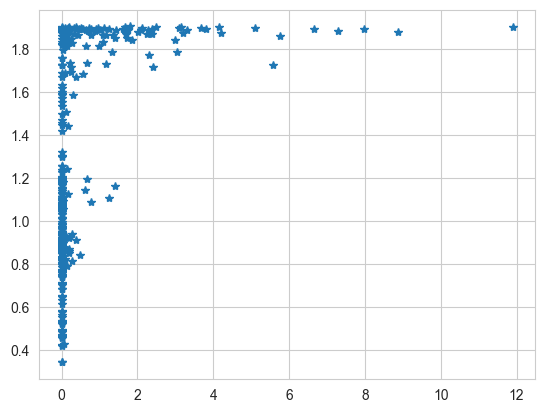

In [18]:
import matplotlib.pyplot as plt
edge_id = 3
v = model.g.edata['v']
plt.plot(flow[edge_id, :], v[edge_id, :], '*')


In [9]:
for i in range(flow.shape[0]):
    plt.plot(flow[i, :], speed[i, :], 'o')

In [200]:
plt.plot(flow[0, :], speed[0, :], '*')
plt.plot(flow[1, :], speed[1, :], 'o')
plt.plot(flow[6, :], speed[6, :], 'o')

In [14]:
for i in range(total_flow.shape[0]):
    plt.plot(total_flow[i, :], v[i, :], 'o')

In [195]:
# distribution plot of the velocity
plt.hist(speed[1, :], bins=20)
plt.show()

In [18]:
plt.hist(speed[0, :], bins=20)
plt.show()

In [197]:
# Extract x_up and x_down from the output
with torch.no_grad():
    v_model = model.velocity_model
    up = v_model.linear12(v_model.relu(v_model.ln11(v_model.dropout(v_model.linear11(x_up)))))
    up = torch.sigmoid(up)
    
    down = v_model.linear22(v_model.relu(v_model.ln21(v_model.dropout(v_model.linear21(x_down)))))
    down = torch.sigmoid(down)

In [198]:
total_up_flow = torch.sum(x_up, dim=2).numpy()
up_flow_v = torch.sum(up, dim=2).numpy()
total_down_flow = torch.sum(x_down, dim=2).numpy()
down_flow_v = torch.sum(down, dim=2).numpy()
for i in range(total_up_flow.shape[0]):
    plt.plot(total_up_flow[i, :], up_flow_v[i, :], '*')

In [199]:
for i in range(total_up_flow.shape[0]):
    plt.plot(total_down_flow[i, :], down_flow_v[i, :], '*')

In [46]:
linear3_params = list(v_model.linear3.parameters())
# Print the parameters or do something with them
for param in linear3_params:
    print(param)

## Visualization

In [6]:
from lib.metric import masked_rmse_np, rho_risk

test_sc = ['sc_sensor/train1', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train11',
            'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4', 'sc_sensor/train12',
            'sc_sensor/train1_2', 'sc_sensor/train7', 'sc_sensor/train8', 'sc_sensor/train13',
            'sc_sensor/train9', 'sc_sensor/train10']

# test_sc = ['sc_sensor/train10']
for i, sc in enumerate(test_sc):
    x, y = sliding_win(data_dict[sc], lags=lags, horizons=pred_horizon)
    if i == 0:
        x_test = x
        y_test = y
    else:
        x_test = np.concatenate([x_test, x], axis=0)
        y_test = np.concatenate([y_test, y], axis=0)

preds_dict = {}
sigma_dict = {}
label_dict = {}


In [7]:
dataset_name, chunk_size, lags, pred_horizon

('train_station', 30, 5, 7)

In [7]:
from lib.utils import sliding_win
import torch
from dgl.data.utils import load_graphs

torch.manual_seed(1)
g_data = load_graphs('./graphs/graphs.bin')    
if dataset_name == "crossroad":
    g = g_data[0][0]
elif dataset_name == "train_station":
    g = g_data[0][1]
    inbound_node = [3, 7, 4, 8, 11, 14, 17, 18, 21, 0]
    outbound_node = [2, 6, 5, 9, 10, 15, 16, 19, 20, 1]
    node_of_interest = outbound_node + [22, 23, 12, 13]
elif dataset_name == "maze":
    g = g_data[0][2]
    
src, dst = g.edges()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# UQ
# from src.Diffusion_Network4_UQ import Diffusion_Model_UQ
# from baselines.LSTM_UQ import SimpleLSTM_UQ
# from baselines.GCN_LSTM_UQ import GCN_LSTM_UQ
# from baselines.DeepAR import DeepAR

# label = y_test.transpose(2, 0, 1)
# # label2 = y_test2.transpose(2, 0, 1)
# x = np.arange(0, label.shape[1])

# diffusion_model_uq = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, scalar=None, device=device)

# # diffusion_model_uq.load_state_dict(torch.load('./checkpoint/diffusion/offline_diffusion_uq4_train.pth'))
# # if dataset_name == "crossroad":
# diffusion_model_uq.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_UQ_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
# # if dataset_name == "train_station":
# #     diffusion_model_uq.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_UQ_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
# # if dataset_name == "maze":
# #     diffusion_model_uq.load_state_dict(torch.load(f"./checkpoint/diffusion/Online_Diffusion_UQ_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
# deepar = DeepAR(input_size_per_node=1, # Assuming input feature is just the target value
#                    hidden_size=64,        # Example hyperparameter
#                    num_nodes=num_nodes,
#                    num_layers=2,          # Example hyperparameter
#                    pred_horizon=pred_horizon-1)
# deepar.load_state_dict(torch.load(f"./checkpoint/deepar/deepar_{dataset_name}_lags{lags}_hor{pred_horizon}_best.pth"))

# lstm_uq = SimpleLSTM_UQ(input_size=num_nodes, hidden_size=64, output_size=pred_horizon-1, num_layers=2, num_nodes=num_nodes)
# lstm_uq.load_state_dict(torch.load(f"./checkpoint/lstm/Online_LSTM_UQ_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))




<All keys matched successfully>

In [9]:

# load pred_cat, label_cat and sigma via directly inference
import matplotlib.pyplot as plt
import dgl

#deepar
# with torch.no_grad():
#     deepar.eval()
#     preds_dict["deepar"], sigma_dict["deepar"] = deepar.inference(torch.FloatTensor(x_test))
#     preds_dict["deepar"] = preds_dict["deepar"].numpy().transpose(2, 0, 1)
#     sigma_dict["deepar"] = sigma_dict["deepar"].numpy()

# add self loop

# with torch.no_grad():
#     # x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
#     # x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
#     x = torch.FloatTensor(x_test.transpose(2, 0, 1))
#     y = torch.FloatTensor(y_test.transpose(2, 0, 1))
#     diffusion_model_uq.g = g
#     g.ndata['feature'] = x # [node, batch_size, num_timesteps_input]
#     g.ndata['label'] = y # [node, batch_size, pred_horizon]
#     # v = model.velocity_model(x_up, x_down).numpy()
#     pred, multi_step_pred = diffusion_model_uq.inference(g.ndata['feature'][src], g.ndata['feature'][dst])
#     preds_dict["diffusionuq"] = multi_step_pred.numpy()
#     sigma_dict["diffusionuq"] = g.ndata['sigma'].numpy()

# with torch.no_grad():
#     multi_step_pred, sigma_lstm = lstm_uq(torch.FloatTensor(x_test))
#     multi_step_pred = multi_step_pred.reshape(multi_step_pred.shape[0], pred_horizon-1, num_nodes).permute(2, 0, 1)
#     multi_step_pred = multi_step_pred.numpy()
#     preds_dict["lstmuq"] = multi_step_pred.clip(min=0)
#     sigma_dict["lstmuq"] = sigma_lstm.numpy().T

# # GCN LSTM UQ
# g = dgl.add_self_loop(g)
# gcnlstm_uq = GCN_LSTM_UQ(in_feats=num_input_timesteps, h_feats=32, out_feats=pred_horizon-1, lstm_hidden_size=32, num_layers=2, g=g)
# gcnlstm_uq.load_state_dict(torch.load(f"./checkpoint/gcn/Online_GCNLSTM_UQ_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))
# with torch.no_grad():
#     multi_step_pred, sigma_gcn = gcnlstm_uq(g, g.ndata['feature'])
#     # multi_step_pred = multi_step_pred.reshape(multi_step_pred.shape[0], pred_horizon-1, num_nodes).permute(2, 0, 1)
#     multi_step_pred = multi_step_pred.numpy()
#     preds_dict["gcnlstmuq"] = multi_step_pred.clip(min=0)
#     sigma_dict["gcnlstmuq"] = sigma_gcn.numpy().T


In [38]:
# load pred_cat, label_cat and sigma via recording the inference process
for name in ['Online_LSTM_UQ', 'Online_Diffusion_UQ', 'Online_GCNLSTM_UQ', 'Online_DeepAR']:
    pred_cat = np.load(f'checkpoint/{name}_{dataset_name}_pred_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')
    label_cat = np.load(f'checkpoint/{name}_{dataset_name}_label_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')
    sigma = np.load(f'checkpoint/{name}_{dataset_name}_sigma_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')
    
    preds_dict[name] = pred_cat
    sigma_dict[name] = sigma.T
    label_dict[name] = label_cat
    
# load pred_cat label_cat for diffusion uq without OL
# pred_cat = np.load(f'checkpoint/wo_ol_Online_Diffusion_UQ_{dataset_name}_pred_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')
# label_cat = np.load(f'checkpoint/wo_ol_Online_Diffusion_UQ_{dataset_name}_label_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')
# sigma = np.load(f'checkpoint/wo_ol_Online_Diffusion_UQ_{dataset_name}_sigma_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy')

# preds_dict["wo_ol_Online_Diffusion_UQ"] = pred_cat
# sigma_dict["wo_ol_Online_Diffusion_UQ"] = sigma.T
# label_dict["wo_ol_Online_Diffusion_UQ"] = label_cat


Rho Risk: 360196.81027071574


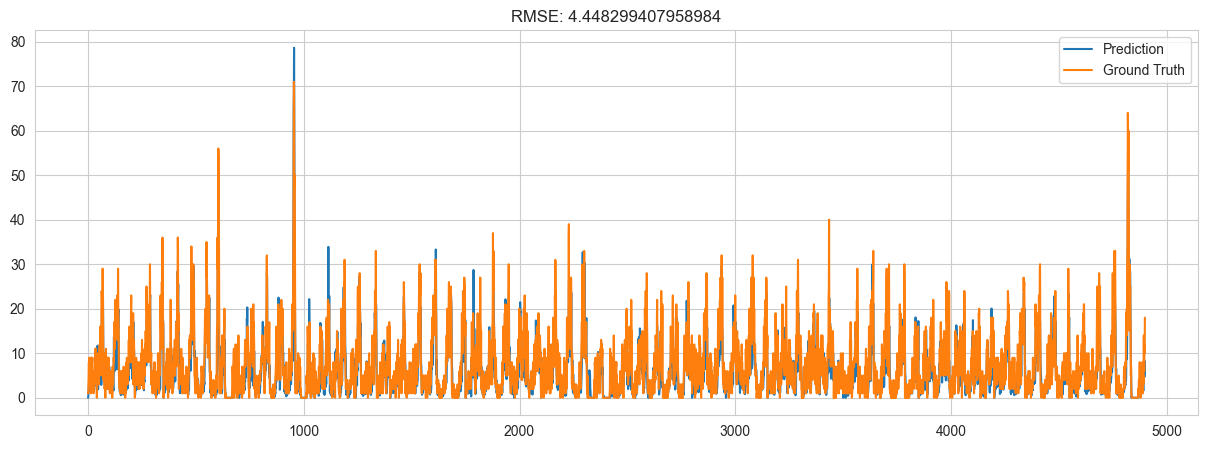

In [30]:

import matplotlib.pyplot as plt
step = 0
node_id = 22

# label = g.ndata['label'][:,:, 0].numpy()
# multi_step_pred = multi_step_pred.numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
# plt.ylim(-5, 30)
plt.plot(x, preds_dict["Online_Diffusion_UQ"][node_id, :, step])
plt.plot(x, label[node_id, :, step])
rmse = masked_rmse_np(preds_dict["Online_Diffusion_UQ"][node_id, :, step], label[node_id, :, step])
rt = np.sum(rho_risk(preds_dict["Online_Diffusion_UQ"][node_id, :], label[node_id, :], timespan=3, rho=0.9))
# wt = weighted_average_loss(pred, label, rho=0.9, timespan=2)
plt.legend(['Prediction', 'Ground Truth'])
plt.title(f'RMSE: {rmse}')
print(f"Rho Risk: {rt}")

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import nbinom
# Set the style
# sns.set_style("whitegrid")

def get_nb_prediction_interval(mu, sigma, confidence=0.95):
    """Calculate prediction interval for Negative Binomial distribution"""
    p = 1 / (1 + mu * sigma)
    n = 1 / (sigma + 1e-10)
    alpha = (1 - confidence) / 2
    lower = nbinom.ppf(alpha, n, p)
    upper = nbinom.ppf(1 - alpha, n, p)
    # if confidence == 0:
    #     print(lower, upper)
    return lower, upper

def visualize_prediction_interval(node_id, step, multi_step_pred, label, sigma, x, confidence=0.8):
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Convert data to DataFrame
    df = pd.DataFrame({
        'Time Steps': x,
        'Prediction': multi_step_pred[node_id, :, step],
        'Ground Truth': label[node_id, :, step]
    })

    # Reshape data for seaborn
    df_melted = df.melt(id_vars=['Time Steps'], 
                        var_name='Type',
                        value_name='Flow Count')

    # Create the main plot
    sns.lineplot(data=df_melted, 
                x='Time Steps', 
                y='Flow Count',
                hue='Type',
                style='Type',
                # markers=True,
                dashes=False,
                markersize=8,
                markevery=5,
                linewidth=2,
                palette={'Prediction': '#2E86C1', 'Ground Truth': '#E74C3C'},
                ax=ax)

    # Calculate and plot prediction intervals
    # sigma = g.ndata['sigma'].numpy()
    alpha = confidence
    lower, upper = get_nb_prediction_interval(
        multi_step_pred[node_id, :, step],
        sigma[node_id, :],
        confidence=alpha
    )

    # Add prediction interval
    ax.fill_between(x, lower, upper, 
                    alpha=0.3, 
                    color='#7FB3D5',
                    label=f'{int(alpha*100)}% Prediction Interval')

    # Customize fonts
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24

    # Set axis labels
    ax.set_xlabel('Time Steps', fontsize=20)
    ax.set_ylabel('Flow Count', fontsize=20)

    # Set y-axis limits and ticks
    ax.set_ylim(-5, 100)
    # Set fewer y-ticks (only show 0, 20, 40, 60, 80)
    ax.set_yticks([0, 20, 40, 60, 80])

    # Customize tick parameters
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Customize grid
    ax.grid(False, linestyle='--', alpha=0.7)

    # Customize legend
    ax.legend(fontsize=15,
            frameon=True,
            fancybox=True,
            shadow=True,
            ncol=1,
            loc='upper right')

    # Remove top and right spines
    sns.despine()

    # Adjust layout
    plt.tight_layout()

    plt.show()

RMSE: 4.45
Rho Risk: 254474.69


/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_99302/107904092.py:83: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.7)


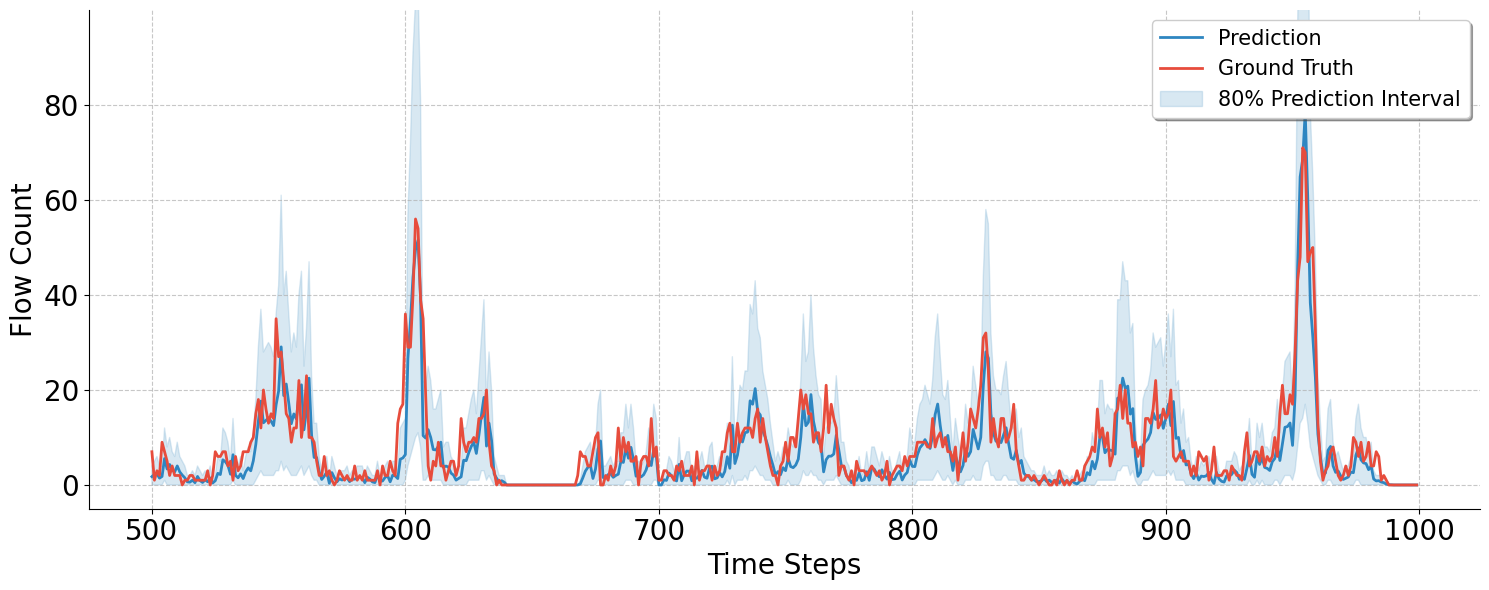

In [21]:

# Print metrics
rmse = masked_rmse_np(preds_dict["Online_Diffusion_UQ"][node_id, :, step], label[node_id, :, step])
rt = np.sum(rho_risk(preds_dict["Online_Diffusion_UQ"][node_id, :], label[node_id, :], timespan=2, rho=0.9))
print(f"RMSE: {rmse:.2f}")
print(f"Rho Risk: {rt:.2f}")
visualize_prediction_interval(node_id, step, preds_dict["Online_Diffusion_UQ"][:, 500:1000, :], label[:,500:1000,:], sigma_dict["Online_Diffusion_UQ"][:, 500:1000], x[500:1000], confidence=0.9)


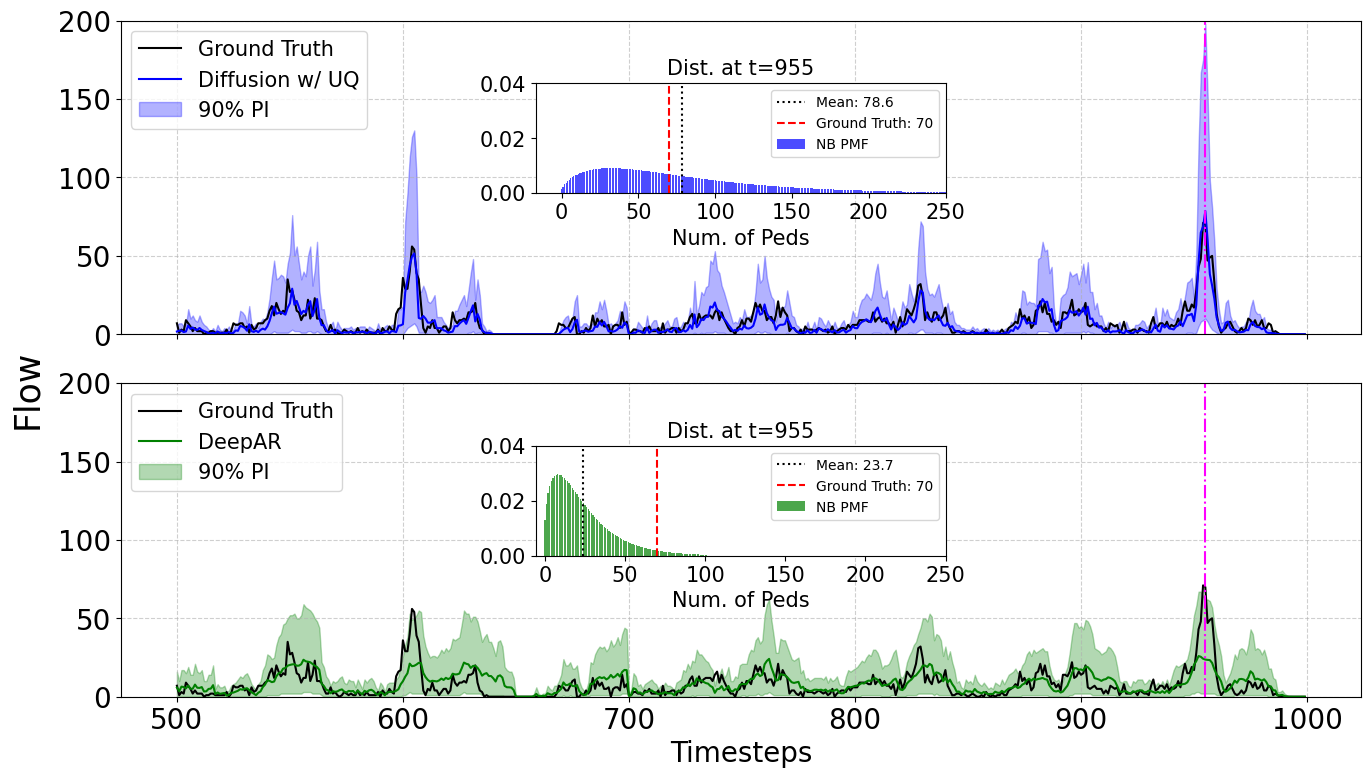

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
confidence = 0.9
time_slice = slice(500, 1000)
# Ensure ts_dist is within the original data range
# AND falls within the plotted time_slice for visual relevance
ts_dist = 955 # Example: Choose a timestep within the 500-1000 slice
model1_key = "Online_Diffusion_UQ"
model2_key = "Online_DeepAR"
model_names = {model1_key: "Diffusion w/ UQ", model2_key: "DeepAR"}
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True) # Share x-axis vertically
axes = axes.flatten()

# --- Plot 1: Diffusion UQ Interval (Top: axes[0]) ---
ax1 = axes[0]
pred1 = preds_dict[model1_key][node_id, time_slice, step]
sigma1 = sigma_dict[model1_key][node_id, time_slice]
label1 = label[node_id, time_slice, step]
x_vals1 = x[time_slice] # Time indices corresponding to the slice
lower1, upper1 = get_nb_prediction_interval(pred1, sigma1, confidence)

ax1.plot(x_vals1, label1, 'k-', linewidth=1.5, label='Ground Truth')
ax1.plot(x_vals1, pred1, 'b-', linewidth=1.5, label='Diffusion w/ UQ')
ax1.fill_between(x_vals1, lower1, upper1, color='blue', alpha=0.3, label=f'{int(confidence*100)}% PI')
# ax1.set_title(f"{model_names[model1_key]} Prediction Interval (t={time_slice.start}-{time_slice.stop-1})")
# ax1.set_ylabel("Count")

# Don't create legend yet - wait until after adding vertical line
# ax1.legend(loc='upper left', fontsize=15) <- Remove this line

ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 200)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# --- Add Vertical Line for Distribution Timestep ---
# Check if ts_dist is within the plotted time range
if time_slice.start <= ts_dist < time_slice.stop:
    ax1.axvline(ts_dist, color='magenta', linestyle='-.', linewidth=1.5)
    # Create legend once with fontsize parameter
    ax1.legend(loc='upper left', fontsize=15)
else:
    print(f"Warning: ts_dist ({ts_dist}) is outside the plotted time_slice ({time_slice.start}-{time_slice.stop-1}). Vertical line not shown.")
    # Still need to create legend if vertical line wasn't added
    ax1.legend(loc='upper left', fontsize=15)


# --- Create Inset Axes for Distribution Plot ---
# Position: [left, bottom, width, height] relative to ax1 bounds
inset_width = 0.33
inset_height = 0.35
inset_left = (1 - inset_width) / 2
inset_bottom = (1 - inset_height) - 0.2
ax_inset = ax1.inset_axes([inset_left, inset_bottom, inset_width, inset_height]) # *** CENTERED POSITION ***

# --- Plot Distribution on Inset Axes ---
mean_dist = preds_dict[model1_key][node_id, ts_dist, step]
sigma_dist = sigma_dict[model1_key][node_id, ts_dist]
actual_dist = label[node_id, ts_dist, step]

if sigma_dist > 1e-9 and mean_dist >= 0:
    n_dist = 1.0 / sigma_dist
    p_dist = 1.0 / (1.0 + sigma_dist * mean_dist)
    p_dist = np.clip(p_dist, 1e-9, 1.0 - 1e-9)

    std_dev_est = np.sqrt(mean_dist + mean_dist**2 * sigma_dist)
    max_val = int(mean_dist + 4 * std_dev_est) + 1
    plot_max_x = max(max_val, actual_dist + 5)
    dist_x = np.arange(0, plot_max_x)
    pmf_values = nbinom.pmf(dist_x, n=n_dist, p=p_dist)

    ax_inset.bar(dist_x, pmf_values, alpha=0.7, label='NB PMF', color='blue')

    ax_inset.axvline(mean_dist, color='black', linestyle=':', linewidth=1.5, label=f'Mean: {mean_dist:.1f}')
    ax_inset.axvline(actual_dist, color='red', linestyle='--', linewidth=1.5, label=f'Ground Truth: {actual_dist}')

    # Simplified inset styling
    ax_inset.set_title(f"Dist. at t={ts_dist}", fontsize=15)
    ax_inset.set_xlabel("Num. of Peds", fontsize=15)
    ax_inset.set_ylim(0, 0.04)
    ax_inset.set_xlim(None, 250)
    ax_inset.legend(fontsize=10)
    ax_inset.tick_params(axis='x', labelsize=15)
    ax_inset.tick_params(axis='y', labelsize=15)
    
else:
    ax_inset.text(0.5, 0.5, "Invalid data", ha='center', va='center', transform=ax_inset.transAxes)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

# --- Plot 2: DeepAR Interval (Bottom: axes[1]) ---
ax2 = axes[1]
pred2 = preds_dict[model2_key][node_id, time_slice, step]
label2 = label[node_id, time_slice, step]
x_vals2 = x[time_slice]

ax2.plot(x_vals2, label2, 'k-', linewidth=1.5, label='Ground Truth')
ax2.plot(x_vals2, pred2, 'g-', linewidth=1.5, label=model_names[model2_key])

if model2_key in sigma_dict:
    sigma2 = sigma_dict[model2_key][node_id, time_slice]
    lower2, upper2 = get_nb_prediction_interval(pred2, sigma2, confidence)
    ax2.fill_between(x_vals2, lower2, upper2, color='green', alpha=0.3, label=f'{int(confidence*100)}% PI')
else:
    print(f"Note: Sigma values not found for {model_names[model2_key]}. Plotting mean prediction only.")

ax2.axvline(ts_dist, color='magenta', linestyle='-.', linewidth=1.5)
# ax2.set_title(f"{model_names[model2_key]} Prediction Interval (t={time_slice.start}-{time_slice.stop-1})")
ax2.set_xlabel("Timesteps", fontsize=20)
# ax2.set_ylabel("Count", fontsize=20)
ax2.legend(loc='upper left', fontsize=15)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 200)
#set x tick fontsize
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
# --- Plot Distribution on Inset Axes ---
ax_inset2 = ax2.inset_axes([inset_left, inset_bottom, inset_width, inset_height]) # *** CENTERED POSITION ***
mean_dist = preds_dict[model2_key][node_id, ts_dist, step]
sigma_dist = sigma_dict[model2_key][node_id, ts_dist]
actual_dist = label[node_id, ts_dist, step]

if sigma_dist > 1e-9 and mean_dist >= 0:
    n_dist = 1.0 / sigma_dist
    p_dist = 1.0 / (1.0 + sigma_dist * mean_dist)
    p_dist = np.clip(p_dist, 1e-9, 1.0 - 1e-9)

    std_dev_est = np.sqrt(mean_dist + mean_dist**2 * sigma_dist)
    max_val = int(mean_dist + 4 * std_dev_est) + 1
    plot_max_x = max(max_val, actual_dist + 5)
    dist_x = np.arange(0, plot_max_x)
    pmf_values = nbinom.pmf(dist_x, n=n_dist, p=p_dist)

    ax_inset2.bar(dist_x, pmf_values, alpha=0.7, label='NB PMF', color='green')

    ax_inset2.axvline(mean_dist, color='black', linestyle=':', linewidth=1.5, label=f'Mean: {mean_dist:.1f}')
    ax_inset2.axvline(actual_dist, color='red', linestyle='--', linewidth=1.5, label=f'Ground Truth: {actual_dist}')

    # Simplified inset styling
    ax_inset2.set_title(f"Dist. at t={ts_dist}", fontsize=15)
    ax_inset2.set_xlabel("Num. of Peds", fontsize=15)
    ax_inset2.set_ylim(0, 0.04)
    ax_inset2.set_xlim(None, 250)
    ax_inset2.tick_params(axis='x', labelsize=15)
    ax_inset2.tick_params(axis='y', labelsize=15)
    ax_inset2.legend(fontsize=10)
    
else:
    ax_inset2.text(0.5, 0.5, "Invalid data", ha='center', va='center', transform=ax_inset2.transAxes)
    ax_inset2.set_xticks([])
    ax_inset2.set_yticks([])

# set union y label
fig.supylabel("Flow", fontsize=25)
# --- Layout and Show ---
plt.tight_layout(pad=1.5)
# save figure as pdf
# plt.savefig(f'./fig/diffusion_vs_deepar_prediction_interval.pdf')
plt.show()

Rho Risk: 17171.916756069288


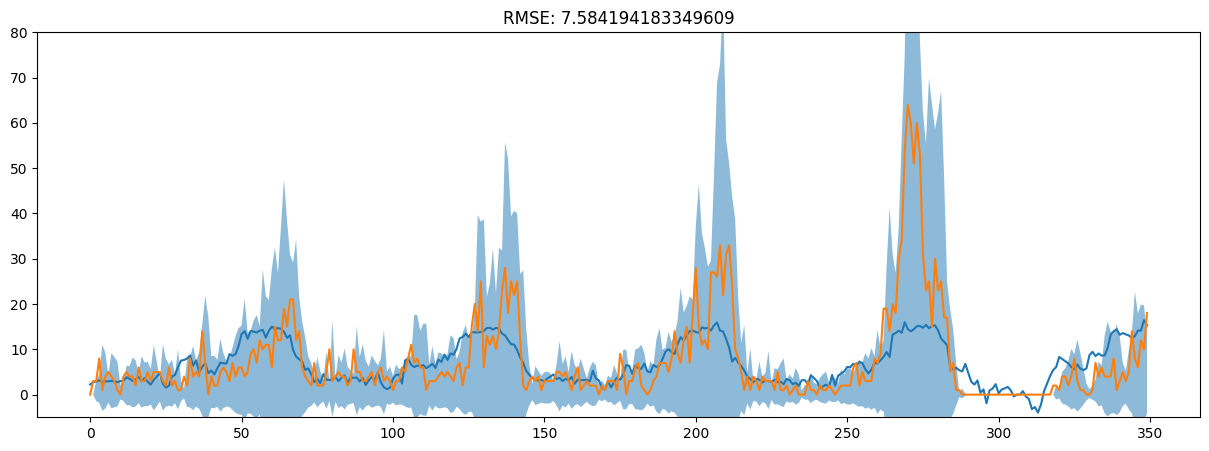

In [17]:
# plot prediction interval (old version, gaussian not negative binomial)

#adjust figure size
plt.figure(figsize=(15, 5))
# plt.plot(x, pred[id, :, 0])
# plt.plot(x, label[id, :, 0])
plt.plot(x, multi_step_pred[node_id, :, step])
plt.plot(x, label[node_id, :, step])
sigma = g.ndata['sigma'].numpy()
sigma = np.sqrt(pred + pred ** 2 * sigma)  # not exactly the right way to visualize the uncertainty
# plot prediction interval
# std_dev = np.sqrt(pred[node_id, :] + pred[node_id, :]**2 * sigma[node_id, :])
# plt.fill_between(x, pred[node_id, :] - 2 * sigma[node_id, :], pred[node_id, :] + 2 * std_dev, alpha=0.5)
plt.fill_between(x, pred[node_id, :] - 2 * sigma[node_id, :], pred[node_id, :] + 2 * sigma[node_id, :], alpha=0.5)
plt.ylim(-5, 80)
# plt.plot(x, v)
rmse = masked_rmse_np(multi_step_pred[node_id, :, step], label[node_id, :, step])
rt = np.sum(rho_risk(multi_step_pred[node_id, :], label[node_id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')
print(f"Rho Risk: {rt}")

7.285278


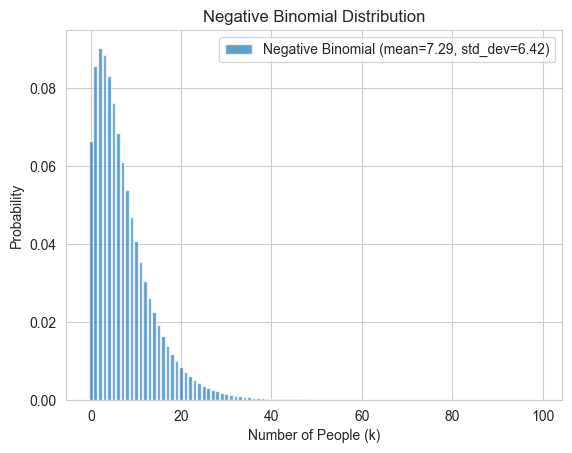

In [18]:
from scipy.stats import nbinom
ts = 270
step = 0 # only step 0 has prediction interval
# id = 2
# Set mean and standard deviation
mean = preds_dict["Online_Diffusion_UQ"][node_id, ts, step]
print(mean)
std_dev = np.sqrt(preds_dict["Online_Diffusion_UQ"][node_id, ts, step] + preds_dict["Online_Diffusion_UQ"][node_id, ts, step]**2 * sigma_dict["Online_Diffusion_UQ"][node_id, ts])

# Calculate shape parameter (k)
# k = (mean ** 2) / (std_dev ** 2)

# Generate x values for the plot
# x_values = np.arange(0, 2 * mean)

x_values = np.arange(0, 100)
# Calculate the probability mass function (PMF) for each x value
# pmf_values = nbinom.pmf(x_values, n=sigma_dict["diffusionuq"][node_id, ts], p=sigma_dict["diffusionuq"][node_id, ts]/(sigma_dict["diffusionuq"][node_id, ts] + mean))
pmf_values = nbinom.pmf(x_values, n=1/sigma_dict["Online_Diffusion_UQ"][node_id, ts], p=1/(1 + sigma_dict["Online_Diffusion_UQ"][node_id, ts] * mean))
# Plot the negative binomial distribution
plt.bar(x_values, pmf_values, label=f'Negative Binomial (mean={mean:.2f}, std_dev={std_dev:.2f})', alpha=0.7)
plt.title('Negative Binomial Distribution')
plt.xlabel('Number of People (k)')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [25]:
# g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
# g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
# z = model.transition_probability(g.ndata['feature'])
# g.ndata['embedding'] = z   # for attention
# g.apply_edges(model.transition_probability.edge_attention)

In [26]:
# with torch.no_grad():
#     num_edges = len(src)
#     sample_size = x_test.shape[0]
#     atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
#     for i in range(num_edges):
#         atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
#     atten_mat = atten_mat.numpy()

Rho Risk: 254474.68873051502


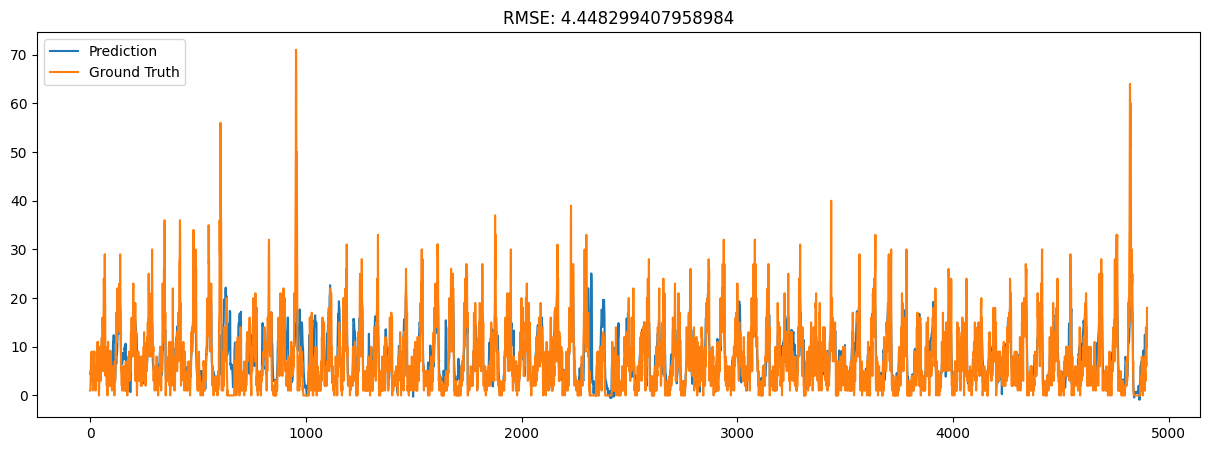

In [42]:
# LSTM UQ

plt.figure(figsize=(15, 5))
# plt.ylim(-5, 40)
x = np.arange(0, label.shape[1])
plt.plot(x, preds_dict["Online_LSTM_UQ"][node_id, :, step])
plt.plot(x, label[node_id, :, step])
plt.legend(['Prediction', 'Ground Truth'])
plt.title(f'RMSE: {rmse}')
print(f"Rho Risk: {rt}")



/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_62095/1877729621.py:83: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.7)


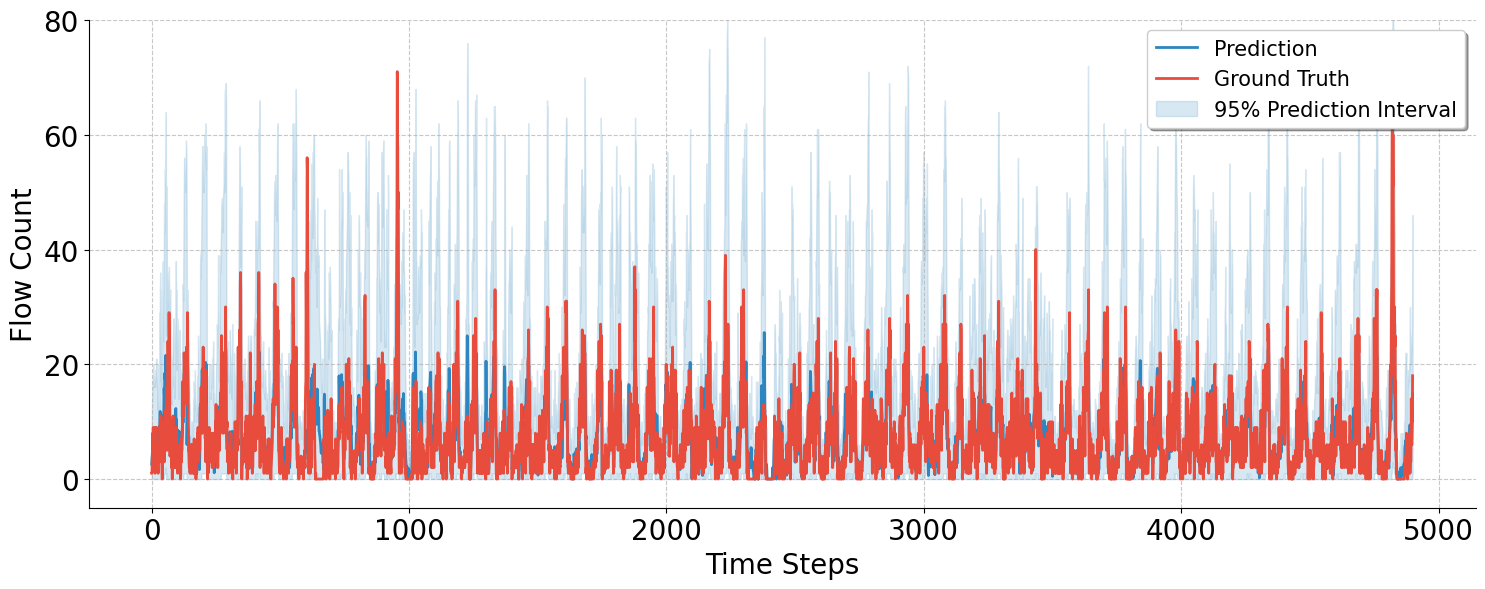

In [43]:
#visualize the prediction interval
visualize_prediction_interval(node_id, step, preds_dict["Online_GCNLSTM_UQ"].clip(min=0), label, sigma_dict["Online_GCNLSTM_UQ"], x, confidence=0.95)

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_62095/1877729621.py:83: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.7)


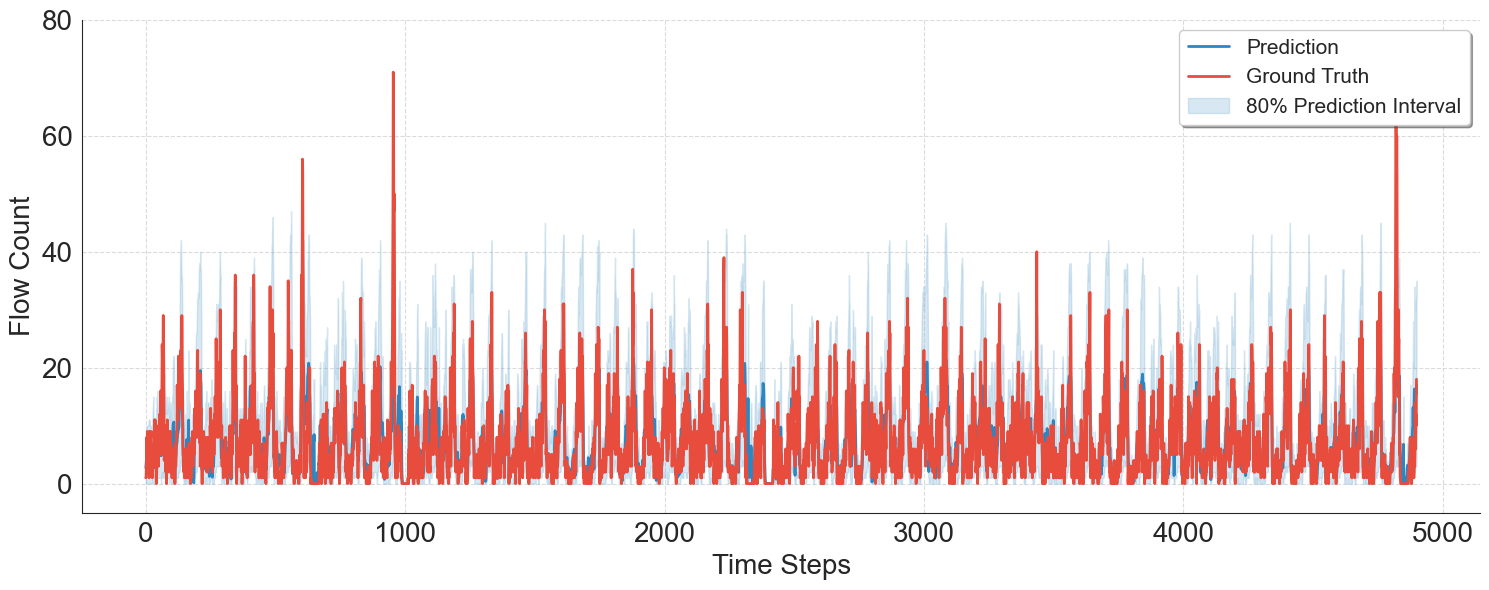

In [54]:
# visualize deepar
visualize_prediction_interval(node_id, step, preds_dict["Online_DeepAR"], label, sigma_dict["Online_DeepAR"], x, confidence=0.8)

In [40]:
# compare models' coverage probability
def coverage_probability(pred, sigma, label, alpha=0.7, threshold=0):
    # Get prediction intervals
    lower, upper = get_nb_prediction_interval(pred, sigma, alpha)
    
    # Create mask for points where label is above threshold
    mask = label >= threshold
    
    # Only consider points above threshold
    if np.sum(mask) == 0:  # Handle case where no points are above threshold
        return 0.0
        
    # Calculate coverage only for masked points
    coverage = np.logical_and(label[mask] >= lower[mask], label[mask] <= upper[mask])
    return np.mean(coverage)

# model_list = ["lstmuq", "diffusionuq", "gcnlstmuq"]
model_list = ["Online_LSTM_UQ", "Online_DeepAR", "Online_GCNLSTM_UQ", "Online_Diffusion_UQ"]
# alpha = 0.9
thresholds = [0, 10, 20, 30, 40, 50, 60, 70]
from collections import defaultdict

coverage_prob_threshold = {}
alpha_list = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
for th in thresholds:
    coverage_prob = defaultdict(list)
    for alpha in alpha_list:
        for model in model_list:
            # cp = coverage_probability(preds_dict[model][node_id, :, step], sigma_dict[model][node_id, :], label[node_id, :, step], alpha=alpha, threshold=th)
            # for all node
            cp = coverage_probability(
                preds_dict[model][node_of_interest, :, step].reshape([-1,]), 
                sigma_dict[model][node_of_interest, :].reshape([-1,]), 
                label[node_of_interest, :, step].reshape([-1,]), 
                alpha=alpha, 
                threshold=th
            )
            # print(f"Model: {model}, alpha: {alpha}, Coverage probability: {cp}, difference: {np.abs(cp - alpha)}")
            coverage_prob[model].append(cp)
    coverage_prob_threshold[th] = coverage_prob
        


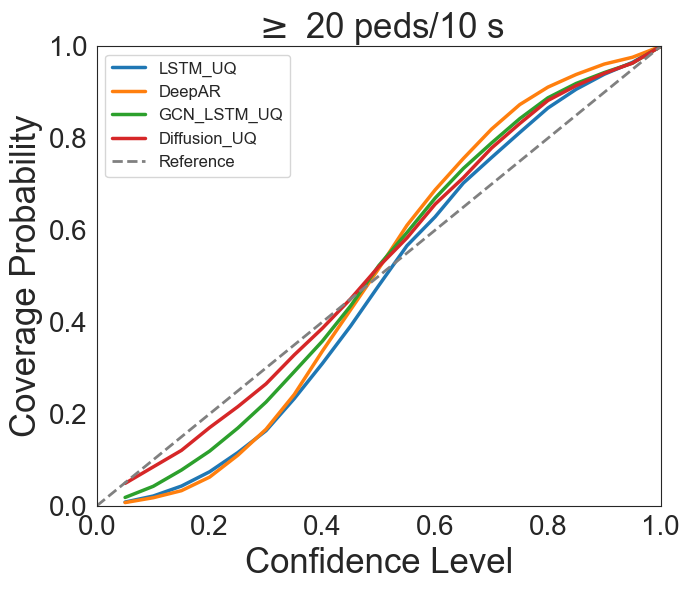

In [30]:
# plot coverage probability vs alpha
import seaborn as sns
# Set the style
sns.set_style("white")
plt.figure(figsize=(7, 6))
model_names = ["LSTM_UQ", "DeepAR", "GCN_LSTM_UQ", "Diffusion_UQ"]
threshold = 20
# Plot lines for each model using seaborn
for i, model in enumerate(model_list):
    sns.lineplot(x=alpha_list, y=coverage_prob_threshold[threshold][model], label=f'{model_names[i]}', linewidth=2.5)

# plot reference line
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Reference', linewidth=2)

# Set the limits and style
plt.xlim(0, 1)
plt.ylim(0, 1)
# Set specific y-axis ticks
# plt.yticks([0, 0.5, 1], fontsize=20)
# plt.xticks([0, 0.5, 1], fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=12, frameon=True)
plt.ylabel('Coverage Probability', fontsize=25)
# plt.xlabel(r'$\alpha$', fontsize=25)
plt.xlabel('Confidence Level', fontsize=25)

plt.title(rf'$\geq$ {threshold} peds/10 s', fontsize=25)

# Adjust layout
plt.tight_layout()
plt.show()


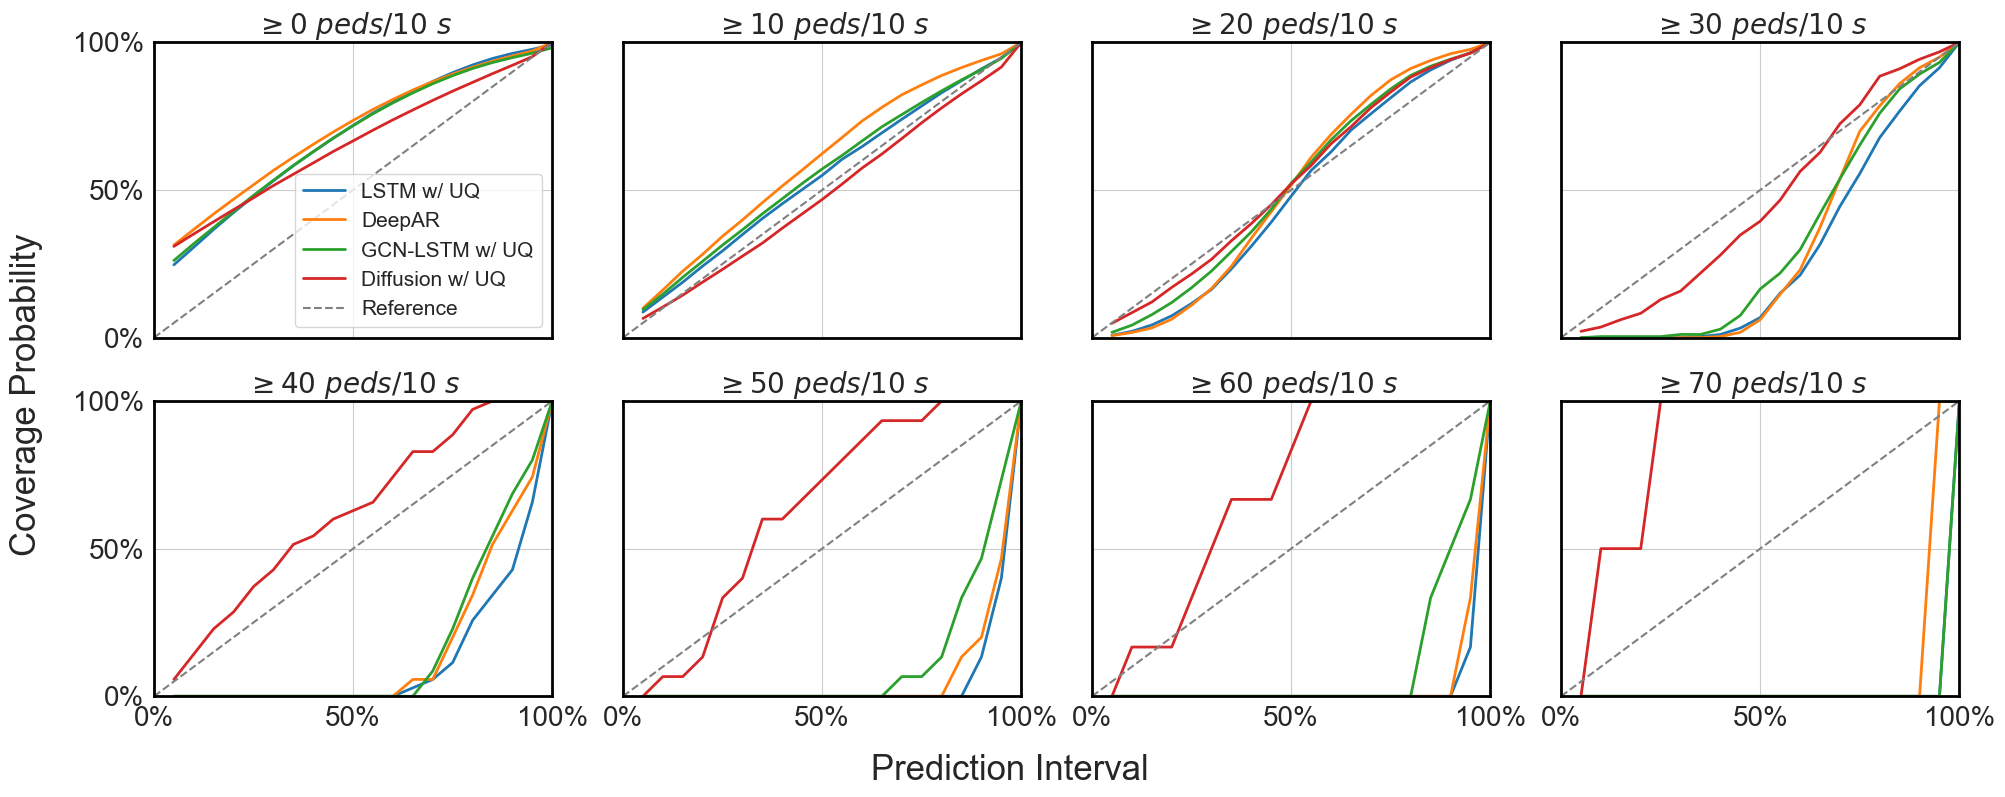

In [41]:
# visualize the calibration curve for each level from peds 0 to 60

model_names = ["LSTM w/ UQ", "DeepAR", "GCN-LSTM w/ UQ", "Diffusion w/ UQ"] # Model names for legend

# Set the style
sns.set_style("whitegrid") # Using whitegrid style for better subplot separation

n_thresholds = len(thresholds)
# Determine grid size (e.g., 3 columns)
ncols = 4
nrows = int(np.ceil(n_thresholds / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey=True)
# Flatten axes array for easy iteration
axes = axes.flatten()

# handles, labels = None, None # Remove this line - no longer needed for combined legend
for i, th in enumerate(thresholds):
    ax = axes[i]
    # Plot lines for each model using seaborn
    for j, model in enumerate(model_list):
        # plot_color = 'red' if model_names[j] == "Diffusion_UQ" else None
        plot_color = None
        sns.lineplot(x=alpha_list, y=coverage_prob_threshold[th][model], label=f'{model_names[j]}', ax=ax, linewidth=2, color=plot_color)

    # plot reference line
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Reference', ax=ax, linewidth=1.5)

    # Set the limits and style
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # Set simplified ticks
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
    ax.tick_params(axis='both', which='major', labelsize=20) # Smaller ticks for subplots
    ax.set_title(rf'$\geq {th}~\mathit{{peds/10~s}}$', fontsize=20)
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)  # Adjust this value to make frame thicker or thinner
        # color
        spine.set_color('black')


    # Manage legends: Show only in the first plot (i=0)
    if i == 0:
         # Optionally adjust legend appearance if needed (e.g., fontsize)
        ax.legend(fontsize=15, frameon=True) # Keep legend for the first plot
    else:
        # Remove individual legends from other subplots
        if ax.get_legend() is not None:
             ax.get_legend().remove()

    # Collect handles and labels from the last plot for the main legend - REMOVED this section
    # if i == n_thresholds -1:
    #     handles, labels = ax.get_legend_handles_labels()

    # Add axis labels only to outer plots
    # if i % ncols == 0: # Leftmost column
    #     ax.set_ylabel('Coverage Probability', fontsize=25)
    # if i >= n_thresholds - ncols: # Bottom row
    #     ax.set_xlabel('Confidence Level', fontsize=25)

fig.supxlabel('Prediction Interval', fontsize=25)
fig.supylabel('Coverage Probability', fontsize=25, x=0)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend below the figure - REMOVED this section
# if handles and labels:
#     # Filter out duplicate 'Reference' labels if seaborn adds multiple
#     unique_labels = {}
#     unique_handles = []
#     for handle, label in zip(handles, labels):
#         if label not in unique_labels:
#             unique_labels[label] = handle
#             unique_handles.append(handle)
#     fig.legend(unique_handles, unique_labels.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_labels), fontsize=12, frameon=True)


# Adjust layout to prevent overlap
plt.tight_layout() # Removed rect argument as space below is no longer needed for legend
# save the figure as a pdf
# plt.savefig(f'./fig/calibration_curve_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pdf', bbox_inches='tight')
plt.show()


In [176]:
# LSTM
from baselines.LSTM import SimpleLSTM
lstm = SimpleLSTM(input_size=num_nodes, hidden_size=64, output_size=pred_horizon-1, num_layers=2, num_nodes=num_nodes)
lstm.load_state_dict(torch.load(f"./checkpoint/lstm/Online_LSTM_{dataset_name}_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pth"))

In [177]:
with torch.no_grad():
    multi_step_pred = lstm(torch.FloatTensor(x_test))
    multi_step_pred = multi_step_pred.reshape(multi_step_pred.shape[0], pred_horizon-1, num_nodes).permute(2, 0, 1)
    multi_step_pred = multi_step_pred.numpy()
    label = y_test.transpose(2, 0, 1)
    
    x = np.arange(0, label.shape[1])
    
    #adjust figure size
    plt.figure(figsize=(15, 5))
    plt.ylim(-5, 40)
    plt.plot(x, multi_step_pred[node_id, :, step])
    plt.plot(x, label[node_id, :, step])
    rmse = masked_rmse_np(multi_step_pred[node_id, :, step], label[node_id, :, step])
    rt = np.sum(rho_risk(multi_step_pred[node_id, :], label[node_id, :], timespan=3, rho=0.9))
    plt.legend(['Prediction', 'Ground Truth'])
    plt.title(f'RMSE: {rmse}')
print(f"Rho Risk: {rt}")

In [26]:
# xgboost
import xgboost as xgb
loaded_model = xgb.Booster()
loaded_model.load_model('./checkpoint/xgboost/offline_xgboost_train_station.model')
# loaded_model.load_model('./checkpoint/xgboost/xgboost_cross.model')

In [27]:
horizon = pred_horizon - 1
x = x_test.reshape([-1, num_input_timesteps * num_nodes])
# y = y_test.reshape([-1, pred_horizon * num_nodes])
# y_test = y_test.reshape([-1, num_input_timesteps * num_nodes])
pred = loaded_model.predict(xgb.DMatrix(x))
# pred = pred.reshape([num_nodes, -1, horizon])

pred = pred.reshape([-1, horizon, num_nodes]).transpose([2, 0, 1])
# pred = pred.T
x2 = np.arange(0, label.shape[1])
plt.figure(figsize=(15, 5))
plt.plot(x2, pred[id, :, step])  # node ts horizon
plt.plot(x2, label[id, :, step])
# plt.plot(x2, label[0, :])
rmse = masked_rmse_np(pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
plt.title(f'RMSE: {rmse}')

In [135]:
# MA
from baselines.MA import Moving_Average
ma = Moving_Average(horizons=pred_horizon-1)
multi_step_pred = ma.inference(g.ndata['feature']).numpy()
label = y_test.transpose(2, 0, 1)
# x2 = np.arange(0, label.shape[1])
id = node_id
# step = -1
x = np.arange(0, label.shape[1])

plt.figure(figsize=(15, 5))
plt.ylim(-5, 40)
plt.plot(x, multi_step_pred[id, :, step])  # node ts horizon
plt.plot(x, label[id, :, step])
# plt.plot(x2, label[0, :])
rmse = masked_rmse_np(multi_step_pred[node_id, :, step], label[node_id, :, step])
rt = np.sum(rho_risk(multi_step_pred[node_id, :], label[node_id, :], timespan=3, rho=0.9))
plt.legend(['Prediction', 'Ground Truth'])
plt.title(f'RMSE: {rmse}')
print(f"Rho Risk: {rt}")

In [9]:
# gat
from baselines.GAT import GAT
adj_mat = g.adjacency_matrix(transpose=False, scipy_fmt="coo")
gat_model = GAT(g=adj_mat, seq_len=num_input_timesteps, feature_size=1, hidden_dim=32, out_dim=pred_horizon-1, nodes=num_nodes, num_heads=3)
gat_model.load_state_dict(torch.load("./checkpoint/gat/gat_trainstation.pth"))

In [13]:
import matplotlib.pyplot as plt
id = 2
step = 3
# up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
# down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    multi_step_pred = gat_model.inference(g.ndata['feature'].permute(1, 0, 2))
    multi_step_pred = multi_step_pred.numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])

rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

In [43]:
# gcn
from baselines.GCN import GCN
gcn_model = GCN(in_size=num_input_timesteps, hid_size=128, out_size=pred_horizon-1, scalar=None)  # out_size: prediction horizon
gcn_model.load_state_dict(torch.load("./checkpoint/gcn/gcn_trainstation.pth"))

In [44]:
import matplotlib.pyplot as plt
id = 23
step = 3
# up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
# down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
g = dgl.add_self_loop(g)
with torch.no_grad():
    multi_step_pred = gcn_model.inference(g, g.ndata['feature'])
    multi_step_pred = multi_step_pred.numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])

rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

## Visualize Speed and Flow

In [223]:
x_test, y_test = sliding_win(data_dict['sc_sensor/maze14'], lags=lags, horizons=pred_horizon)
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    x = torch.FloatTensor(x_test.transpose(2, 0, 1))
    y = torch.FloatTensor(y_test.transpose(2, 0, 1))
    g.ndata['feature'] = x # [node, batch_size, num_timesteps_input]
    g.ndata['label'] = y # [node, batch_size, pred_horizon]
    # v = model.velocity_model(x_up, x_down).numpy()
    model(g.ndata['feature'][src], g.ndata['feature'][dst])
    # flow = torch.sum(x_up, dim=2).numpy()
    # total_flow = torch.sum(torch.cat([x_up, x_down], dim=-1), dim=-1).numpy()
flow = model.g.edata['message']
speed = model.g.edata['v']
F = model.g.edata['F']

In [226]:
# speed and F
import matplotlib.pyplot as plt
time = np.arange(speed.shape[1])
src_idx = 10
dst_idx = 6
edge_id = np.where((src == src_idx) & (dst == dst_idx))[0]
plt.plot(time, speed[edge_id, :].squeeze())
plt.plot(time, F[edge_id, :].squeeze())

In [227]:
# Flow
plt.plot(time, flow[edge_id, :].squeeze())

In [15]:
# T = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5], [0.1, 0.2, 0.3, 0.4, 0.5]])
# alpha = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])
# F = 1/(1 + alpha * T)
# # f = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])
# n = torch.tensor([[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]])
# for i in zip(n, F):
#     print(i)

In [16]:
# src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 6, 6, 6])
# dst = np.array([4, 2, 7, 1, 4, 7, 2, 7, 1, 2, 4, 1])
# g = dgl.graph((src, dst))
# g.edata['distance'] = torch.FloatTensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]) # 50m
# # save the graph
# with open('graphs/graph_data.pkl', 'wb') as file:
#     pickle.dump(g, file)

In [23]:
# 
v = 40
alpha = np.arange(-1, 1, 0.01)
F = 1/(1+alpha*v)
plt.plot(alpha, F)

In [65]:
v = 3
alpha = np.arange(0.1, 1, 0.01)
F = 1/(1+alpha*v)
plt.plot(alpha, F)